## Kue Dataset - Model4

Model4


In [1]:
# conda install -c conda-forge keras

In [2]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# PATH_DATA = '../data/'
# PATH_DATA_IMAGES = '../../../../My_Dataset/images/dataset257/'
PATH_DATA_IMAGES = 'drive/MyDrive/Repository/Data/dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = 'drive/MyDrive/Repository/Model/'

In [5]:
os.listdir(PATH_DATA_TRAIN)

['.DS_Store',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_risoles',
 'kue_klepon',
 'kue_putri_salju',
 'kue_lumpur',
 'kue_lapis',
 'kue_serabi']

## Modeling

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


In [7]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [77]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 128

In [78]:
# ?Conv2D

In [115]:
just_cake_model = Sequential()
just_cake_model.add(Conv2D(128, (3, 3), activation ='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
just_cake_model.add(Conv2D(128, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Dropout(0.3))
just_cake_model.add(Conv2D(128, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Conv2D(256, (3, 3), activation ='relu',padding = 'same'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Dropout(0.2))
just_cake_model.add(Conv2D(256, (3, 3), activation ='relu',padding = 'same'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Dropout(0.1))
just_cake_model.add(Conv2D(256, (3, 3), activation ='relu',padding = 'same'))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(Dropout(0.1))

just_cake_model.add(Flatten())
just_cake_model.add(Dense(32,activation ='relu'))
just_cake_model.add(Dropout(0.1))
just_cake_model.add(Dense(16,activation ='relu'))
just_cake_model.add(Dense(LABEL_SIZE,activation ='softmax'))

# just_cake_model = load_model(PATH_MODEL +'just_cake_model-colab3.h5',compile=False)

In [116]:
just_cake_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_198 (Conv2D)          (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 124, 124, 128)     147584    
_________________________________________________________________
max_pooling2d_167 (MaxPoolin (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 30, 30, 256)     

In [122]:
## compile model
opt = optimizers.Adam(learning_rate=0.00001)
just_cake_model.compile(
              loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',
                      #  metrics.SparseCategoricalAccuracy(),
                       metrics.AUC()])

In [123]:
## data generator
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.3,
        rotation_range=10,
        # width_shift_range=0.25,
        # height_shift_range=0.25,
        # shear_range=0.25,
        # horizontal_flip=True
        )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Shuffle = True
train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed=301,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [124]:
## save best model and use early stopping
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=8) 
check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model-colab4.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=25)

Epoch 1/25
47/47 [==============================] - 35s 704ms/step - loss: 0.7339 - accuracy: 0.7199 - auc_15: 0.9612 - val_loss: 0.9762 - val_accuracy: 0.6938 - val_auc_15: 0.9312
Epoch 2/25
47/47 [==============================] - 32s 686ms/step - loss: 0.7025 - accuracy: 0.7672 - auc_15: 0.9628 - val_loss: 0.9611 - val_accuracy: 0.6875 - val_auc_15: 0.9330
Epoch 3/25
47/47 [==============================] - 33s 701ms/step - loss: 0.7247 - accuracy: 0.7466 - auc_15: 0.9608 - val_loss: 0.9706 - val_accuracy: 0.6812 - val_auc_15: 0.9315
Epoch 4/25
47/47 [==============================] - 33s 695ms/step - loss: 0.6535 - accuracy: 0.7709 - auc_15: 0.9691 - val_loss: 0.9942 - val_accuracy: 0.6812 - val_auc_15: 0.9300
Epoch 5/25
47/47 [==============================] - 33s 695ms/step - loss: 0.6097 - accuracy: 0.7915 - auc_15: 0.9735 - val_loss: 0.9774 - val_accuracy: 0.6750 - val_auc_15: 0.9320
Epoch 6/25
47/47 [==============================] - 33s 699ms/step - loss: 0.6599 - accuracy: 0

## Evaluations

In [125]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

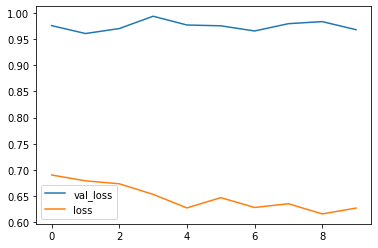

In [126]:
df_epoch_hist[['val_loss','loss']].plot()

In [127]:
# df_epoch_hist.to_csv('../artifact/epoch_hist_2-overfit2.csv')

In [128]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'just_cake_model-colab4.h5')
# model_load = load_model(PATH_MODEL + 'just_cake_model-colab2.h5')
model_load.evaluate(train_generator)

48/48 [==============================] - 30s 623ms/step - loss: 0.5571 - accuracy: 0.8292 - auc_15: 0.9819


[0.557061493396759, 0.829155683517456, 0.9818568825721741]

#### 1. Train

In [129]:
per = np.random.permutation(train_generator.n)
train_generator.index_array = per
# classes = generator.classes[per]

y_true = train_generator.classes[per]
predictions = model_load.predict(train_generator)

# y_true = pd.Series(true_labels)[train_generator.index_array].values
y_pred = np.argmax(predictions, axis=1)

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [130]:
# labels_true = []
# for batch_x, batch_y in train_generator:
#   labels_true.append(batch_y)
# train_generator.index_array
y_true

array([6, 5, 4, ..., 7, 5, 0], dtype=int32)

In [131]:
y_pred

array([6, 5, 4, ..., 7, 5, 0])

In [132]:
# labels_true = np.array(labels_true)
# len(labels_true[10])


In [133]:
# np.argmax(predictions[1])
# imgs, labels = next(val_generator)
# train_generator.labels

In [134]:
# labels[3]

In [135]:
# plt.imshow(imgs[3])

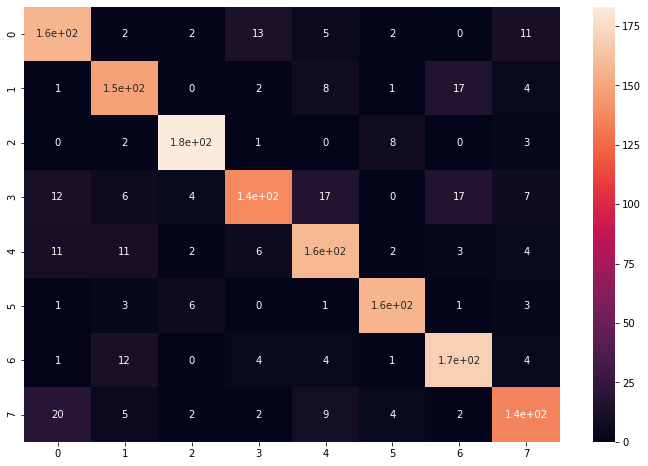

In [136]:
plt.figure(figsize = (12,8))
sns.heatmap(cm, annot= True)

In [137]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       192
           1       0.78      0.82      0.80       181
           2       0.92      0.93      0.92       197
           3       0.83      0.69      0.75       201
           4       0.78      0.80      0.79       197
           5       0.90      0.91      0.90       172
           6       0.81      0.87      0.84       196
           7       0.79      0.76      0.77       180

    accuracy                           0.82      1516
   macro avg       0.82      0.82      0.82      1516
weighted avg       0.82      0.82      0.82      1516



#### 2. Validations

In [138]:
per = np.random.permutation(val_generator.n)
val_generator.index_array = per

y_true_val = val_generator.classes[per]
predictions_val = model_load.predict(val_generator)
y_pred_val = np.argmax(predictions_val, axis=1)

cm_val = sklearn.metrics.confusion_matrix(y_true_val, y_pred_val)

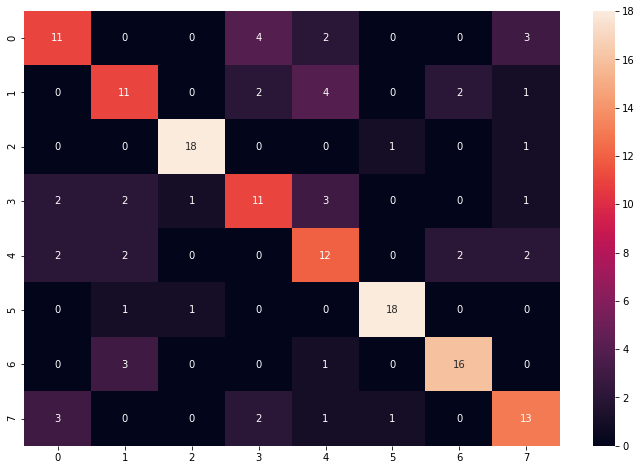

In [139]:
plt.figure(figsize = (12,8))
sns.heatmap(cm_val, annot= True)

In [140]:
print(classification_report(y_true_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.58      0.55      0.56        20
           2       0.90      0.90      0.90        20
           3       0.58      0.55      0.56        20
           4       0.52      0.60      0.56        20
           5       0.90      0.90      0.90        20
           6       0.80      0.80      0.80        20
           7       0.62      0.65      0.63        20

    accuracy                           0.69       160
   macro avg       0.69      0.69      0.69       160
weighted avg       0.69      0.69      0.69       160

